#  Alcohol Image Classifier with Fastai and Google Colab

Using fastai to distinguish different types of alcohol beverages
___

## Section 1 - Setup

Note: Highly recommend to run this notebook on Google Colab. To find out more about Google Colab setup, please visit: https://course.fast.ai/start_colab

Once this notebook is open on Google Colab, do switch on GPU accelerator for the notebook by going to top menu and clicking `Runtime` > `Change runtime type` > Select `GPU` for Hardware Accelerator.

We first mount our Google Drive on our Google Colab runtime. A link will appear in the cell for you to click and retrieve your authorization code. Copy the auth code, paste it in the empty field in the notebook cell, and then press Enter.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Installing the fastai dependencies required. I found this combination to be work well on Google Colab for the purpose of this notebook.

In [2]:
!pip install fastai==2.0.19
!pip install fastai2==0.0.30
!pip install fastcore==1.0.16
!pip install -Uqq fastbook

import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.vision.widgets import *

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 194kB 9.7MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 184kB 9.3MB/s 
     |████████████████████████████████| 40kB 4.5MB/s 
ERROR: fastai 2.0.19 has requirement fastcore<1.4,>=1.3, but you'll have fastcore 1.0.16 which is incompatible.
  Found existing installation: fastcore 1.3.1
    Uninstalling fastcore-1.3.1:
      Successfully uninstalled fastcore-1.3.1
     |████████████████████████████████| 727kB 11.3MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 1.1MB 58.6MB/s 
     |████████████████████████████████| 40kB 6.7MB/s 
     |████████████████████████████████| 92kB 14.0MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████|

Create a directory to store the images that we are about to download

In [4]:
import os
try:
  os.mkdir('images')
except:
  pass

The next thing that needs to be done is to get the API key (for Azure Bing Search V7), since I used it to obtain image datasets. Replace `XXX` with your specific API key. To find out more about how to setup the Azure API key, please have a look at the README file in this GitHub repo.

In [5]:
key = 'XXX'

Once the key has been set, we can run the fastai function `search_images_bing` to retrieve a set of image URLs that contains the keyword of your choice. For example, to find a set of images for `whisky`, we can run the following code.

In [7]:
results = search_images_bing(key, 'whisky')
img_urls = results.attrgot('content_url')
len(img_urls)

150

The function returns a list of 150 image urls related to the keyword `whisky`. Let's have a look at the image of one of these URLs.

In [8]:
img_urls[1]

'http://www.onemoregift.co.uk/wp-content/uploads/2014/11/whisky-1286.jpg'

We download the image from the above URL into a destination file named `whisky_test.jpg` inside our `images` folder, and then display it here as a 128x128 pixel thumbnail.

In [9]:
dest = 'images/whisky_test.jpg'
download_url(img_urls[1], dest)

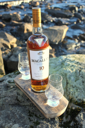

In [10]:
img = Image.open(dest)
img.to_thumb(128,128)

We can see that we got ourselves a Macallan whisky image above, showing that the above chunk of code did work. Therefore, we are now ready to get into main action.
___

## Section 2 - Downloading Image Data

It would be interesting to distinguish the images of alcohol types commonly seen, namely whisky, wine and beer. To do that, we first define the 3 alcohol types in a list, and create a `Path` to store the images for these alcohol types that we are going to download shortly.

In [11]:
alcohol_types = ['whisky','wine','beer']
path = Path('alcohol')

For each of the 3 alcohol types, we create a subpath to store the respective images.

In [12]:
if not path.exists():
    path.mkdir()
    for alcohol in alcohol_types:
        dest = (path/alcohol)
        dest.mkdir(exist_ok=True)
        
        # Obtaining list of image URLs with that alcohol type keyword
        results = search_images_bing(key, f'{alcohol}')
        
        # Downloading images from the list of image URLs
        download_images(dest, urls=results.attrgot('content_url'))

We should now have the images within the respective folders with the label of the alcohol type. In order to confirm this, we can utilize the `get_image_files` function.

In [13]:
img_files = get_image_files(path)
img_files

(#447) [Path('alcohol/wine/00000087.jpg'),Path('alcohol/wine/00000020.jpg'),Path('alcohol/wine/00000070.jpg'),Path('alcohol/wine/00000124.jpg'),Path('alcohol/wine/00000014.jpg'),Path('alcohol/wine/00000108.jpg'),Path('alcohol/wine/00000011.jpg'),Path('alcohol/wine/00000000.png'),Path('alcohol/wine/00000099.jpg'),Path('alcohol/wine/00000122.jpg')...]

fastai conveniently provides a `verify_images` function that allows us to quickly check whether the file is corrupt or not.

In [14]:
failed = verify_images(img_files)
failed

(#8) [Path('alcohol/whisky/00000109.jpeg'),Path('alcohol/whisky/00000060.jpg'),Path('alcohol/whisky/00000008.jpg'),Path('alcohol/beer/00000107.jpg'),Path('alcohol/beer/00000114.jpg'),Path('alcohol/beer/00000059.jpg'),Path('alcohol/beer/00000130.jpg'),Path('alcohol/beer/00000055.png')]

We can then proceed to remove these corrupt files from our dataset, using the `map` and `unlink` methods.

In [15]:
failed.map(Path.unlink);

___
## Section 3 - Preparing Image Datasets

fastai has an extremely flexible system called the *data block API*. With this API, we can fully customize the creation of the `DataLoaders` object. `DataLoaders` can store whatever `DataLoader` objects we place in it, and it is used to generate training and validation sets subsequently. 

In my interpretation, `DataLoaders` is essentially just an object that stores information about what is the data we will be running our model on.

In order to create `DataLoaders`, there are several things we need to specify:  

- **What kinds of data we are working with**
- **How to get the list of items**
- **How to label these items**
- **How to create the validation set**

We begin by first creating a `DataBlock` which will then contain more details. The `DataBlock` is like a template for creating `DataLoaders`.

In [16]:
alcohols = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's go through the above code step by step:

```python
blocks=(ImageBlock, CategoryBlock)  
```
This `blocks` tuple indicates the data types for our *independent* and *dependent* variables respectively. Since our aim here is to classify images, our independent variable is images (`ImageBlock`) while our dependent variable is categories/labels (`Category Block`)
___
```python
get_items=get_image_files
```
The `get_items` argument specifies the function to be used in order to extract the file paths of the images in our dataset. Recall we earlier used the fastai built-in `get_image_files` to get the file paths into the variable `img_files`. This `get_image_files` function takes a path (which we will specify later), and returns a list of all of the images in that path.
___

```python
splitter=RandomSplitter(valid_pct=0.2, seed=1) 
```
The `splitter` method will split the dataset into training and validation sets. We specify `RandomSplitter` to ensure that it is split randomly, and the `valid_pct` argument within it is there to indicate what percentage of the dataset is to be allocated for validation. The random seed can also be set within the `RandomSplitter` for reproducibility of results.


```python
get_y=parent_label 
```
`parent_label` is a function provided by fastai that gets the name of the folder the file is located in. Since we have placed our images in folders with the respective alcohol type name, this `parent_label` will be returning the folder names of whisky, wine and beer.

```python
item_tfms=Resize(128)
```
We normally use resize images into a square as it is easier to do so, since original images can come in different height/width and aspect ratio. To do this, we perform a transformation on each item (`item_tfms`) by resizing it into squares of 128x128 pixels.


Now that all the details and arguments have been provided, we can then proceed to initiate the DataLoaders with the following single line of code. Notice that the argument for `dataloaders` is the `path` where our images are stored i.e. `alcohol` folder path.

In [17]:
dls = alcohols.dataloaders(path)

Let's have a brief look at the images by showing a subset batch of 12 images inside our validation set

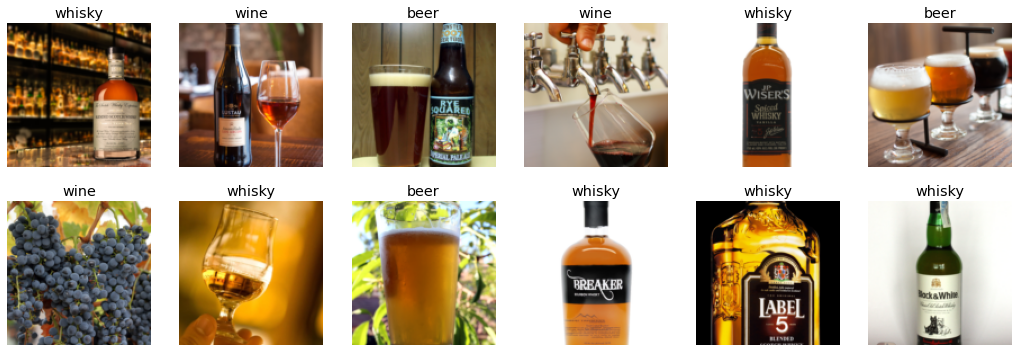

In [18]:
dls.valid.show_batch(max_n=12, nrows=2)

### Data Augmentation

Before proceeding further, it is important to talk about the concept of data augmentation. In order to enrich our training dataset, we can create random variations of our input data, such that they appear different, but do not actually change the meaning of the data.

A common way to do this includes `RandomResizedCrop`, which grabs a random subset of the original image, meaning we actually randomly select part of the image, and crop to just that part.. We use `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform.

What happens is that on each epoch (which is one complete pass through all of our images in the dataset), we randomly select a different part of each image. This means that our model can learn to focus on and recognize different features in our images. It also reflects how images work in the real world, since different photos of the same item may be framed in slightly different ways. The benefit of using this kind of item transformation is that it in turn helps to prevent overfitting.

The `min_scale` parameter specified determines how much of the image to select at minimum each time. With all the above decided, we can create a new `DataBlock` object using the `.new` method, and running it to give us a new `DataLoaders` object named `dls`.

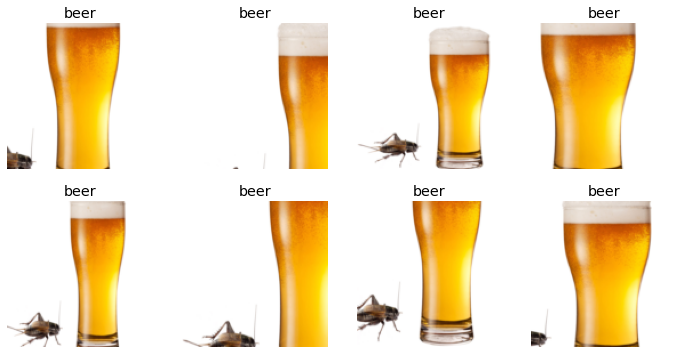

In [19]:
alcohols = alcohols.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = alcohols.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Following the item transformation (`item_tfms`), we run batch transformation (`batch_tfms`) where we apply a standard set of data augmentation transformations (`aug_transforms()`) on the batch of the individual items.

The difference between `item_tfms` and `batch_tfms` is that `item_tfms` performs the transformation on every individual item (e.g. image), whereas `batch_tfms` runs transformation on an entire batch of items. 

Item transformations are for collating and preparing for a batch, and they're run on the CPU. Batch transforms are applied after everything is resized and batched up, and is run on the GPU.

The following code illustrates the effects of the augmentation transformation `aug_transforms` on a single input image.

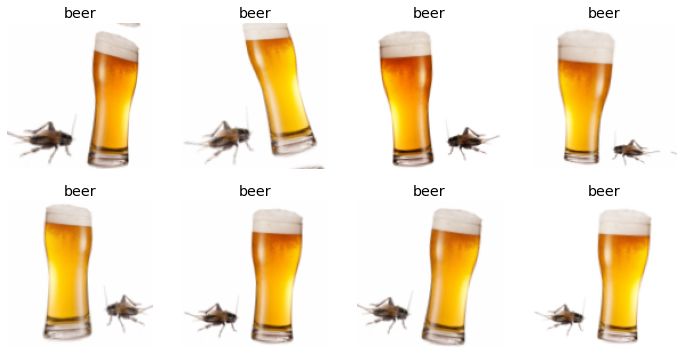

In [20]:
alcohols = alcohols.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = alcohols.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Section 4 - Training the Model

Now that the images are prepared (albeit not cleaned yet), we can start the training to build a simple deep learning model right off the bat. First we prepare the `DataLoaders` object with the following code. In this iteration, we resize and crop our images at sizes of 224x224 pixel, with `min_scale` of 0.5.

In [21]:
alcohols = alcohols.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = alcohols.dataloaders(path)

Convoluted neural network (CNN) is the main type of neural network used for image classification, and we will be using that here. In terms of the architecture, we will be using resnet34 (i.e. 34 layers deep) in our `cnn_learner` fastai function.

We are using the `.fine_tune` method instead of `.fit` because we are performing transfer learning here, by leveraging on the pretrained resnet model. We specify the number of epochs to be 4 (i.e. argument inside `.fine_tune`.

In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

From the above, we can see that after training our CNN learner for about a minute, we actually obtain an error rate of 0.09 (i.e. 91% accuracy). This is a pretty good result for a start, since we have not yet cleaned our data.

In order to better visualize the above results, it is best to illustrate it with a Confusion Matrix.

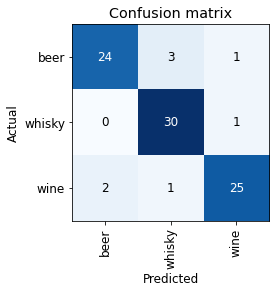

In [23]:
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

fastai also provides a convenient method that allows us to find out which are the images where there was the highest loss. The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. These helps us identify which images where the model had trouble with.

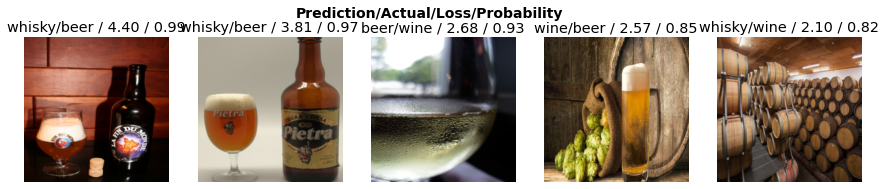

In [24]:
interpretation.plot_top_losses(5, nrows=1)

## Section 5 - Cleaning the Data

Notice that we ran the model before cleaning the data. In fact, doing so makes the data cleaning even easier subsequently. As shown above, the `plot_top_losses` can already indicate which are the images that the model has most trouble with.

The data cleaning process is made easy with the fastai `ImageClassifierCleaner` Graphical User Interface (GUI) widget. 

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


<img src="https://i.ibb.co/4fXZPgx/cleaner-gui.png"/>

The cleaning is done by selecting the options for the respective images above, and then running the following code.

In [30]:
# Delete images marked as delete
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    
# Update category of image to the newly specified category
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

#### Retraining the model after data cleaning

In [32]:
dls = alcohols.dataloaders(path)
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

In [33]:
learn.export()

In [34]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Section 6 - Using Image Classification Model for Inference

After loading the pickle file containing the information of our deep learning image classification model, we can use it to predict the label of new images.

In [35]:
learn_inf = load_learner(path/'export.pkl')

In [36]:
# Sample image
ims = ['https://alcohaul.sg/products/i/400/5f7edfe79ae56e6d7b8b49cf_0.jpg']
dest = 'images/test_whisky.jpg'
download_url(ims[0], dest)

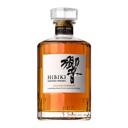

In [37]:
im = Image.open(dest)
im.to_thumb(128,128)

In [38]:
learn_inf.predict('images/test_whisky.jpg')

('whisky', tensor(1), tensor([3.0157e-06, 9.9997e-01, 2.4673e-05]))

In [39]:
learn_inf.dls.vocab

['beer', 'whisky', 'wine']